In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pandas as pd
import re
import random
import string
import matplotlib.pyplot as plt
from utilities import clean_arabic_tweet
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.utils import to_categorical
from utilities import clean_arabic_tweet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, CSVLogger, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,BatchNormalization
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim
import numpy as np
from nltk import ngrams
from sklearn.metrics import classification_report, f1_score
from plot_keras_history import plot_history


In [2]:
pd.set_option('display.max_colwidth', -1)

In [3]:
train_data_path = './cleaned_data/cleaned_train_data_for_subtask1.csv'
test_data_path = './cleaned_data/cleaned_test_data_for_subtask1.csv'

In [4]:
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

<AxesSubplot:>

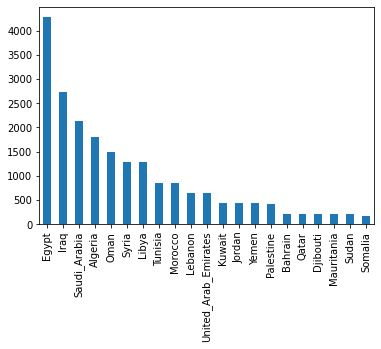

In [5]:
fig, ax = plt.subplots()
train_data['#3_country_label'].value_counts().plot(ax=ax, kind='bar')

In [6]:
train_x = train_data['#2_tweet_clean_V1'].tolist()
train_y = train_data['#classes_id'].tolist()

test_x = test_data['#2_tweet_clean_V1'].tolist()
test_y = test_data['#classes_id'].tolist()

In [7]:
train_data.head()

,#1_tweetid,#2_tweet,#3_country_label,#2_tweet_clean_V1,#2_tweet_clean_V2,#2_tweet_clean_V3,#classes_id
0,TRAIN_0,حاجة حلوة اكيد,Egypt,حاجه حلوه اكيد,حاجه حلوه اكيد,حاجه حلوه اكيد,0
1,TRAIN_1,عم بشتغلوا للشعب الاميركي اما نحن يكذبوا ويغشوا ويسرقوا ويقتلو شعوبهم ويعملوا لصالح اعدائهم,Iraq,عم بشتغلوا لشعب الاميركي اما نحن يكذبوا ويغشوا ويسرقوا ويقتلو شعوبهم ويعملوا لصالح اعداهم,عم بشتغلوا لشعب الاميركي يكذبوا ويغشوا ويسرقوا ويقتلو شعوبهم ويعملوا لصالح اعداهم,عم بشتغلوا لشعب الاميركي يكذبوا ويغشوا ويسرقوا ويقتلو شعوبهم ويعملوا لصالح اعداهم,1
2,TRAIN_2,ابشر طال عمرك,Saudi_Arabia,ابشر طال عمرك,ابشر طال عمرك,ابشر طال عمرك,2
3,TRAIN_3,منطق 2017: أنا والغريب علي إبن عمي وأنا والغريب وإبن عمي علي أخويا. #قطع_العلاقات_مع_قطر #موريتانيا_مع_قطر,Mauritania,منطق انا والغريب علي ابن عمي وانا والغريب وابن عمي علي اخويا قطع العلاقات مع قطر موريتانيا مع قطر,منطق والغريب ابن عمي وانا والغريب وابن عمي اخويا قطع العلاقات قطر موريتانيا قطر,منطق والغريب ابن عمي وانا وابن اخويا قطع العلاقات قطر موريتانيا,3
4,TRAIN_4,شهرين وتروح والباقي غير صيف ملينا,Algeria,شهرين وتروح والباقي غير صيف ملينا,شهرين وتروح والباقي صيف ملينا,شهرين وتروح والباقي صيف ملينا,4


## tokanize the trainset for creating the embedding layer

In [8]:
vocab_size = 50000
embedding_dim = 64
max_length = 80
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [9]:
tokenizer = Tokenizer(oov_token=oov_tok, num_words=vocab_size)
tokenizer.fit_on_texts(train_x)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(train_x)

## padding/truncating tweets to be the same length

In [10]:
training_sequences = tokenizer.texts_to_sequences(train_x)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(test_x)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## convert labels to categorical from class id to categorical vector

In [11]:
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

In [12]:
training_padded = np.array(training_padded)
training_labels = train_y
testing_padded = np.array(testing_padded)
testing_labels = test_y

import keras
import tensorflow
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense

model = keras.Sequential()
model.add(Embedding(max_no, dim, input_shape=(sql_len,)))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(21, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 20
batch_size = 64

history = model.fit(X_tr, Y_tr, epochs=epochs, batch_size=batch_size,validation_split=0.1)## create the lstm Model

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.SpatialDropout1D(0.1),
    tf.keras.layers.LSTM(embedding_dim, dropout=0.1,recurrent_dropout=0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(21, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 80, 64)            3200000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 80, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 21)                1365      
Total params: 3,238,549
Trainable params: 3,238,549
Non-trainable params: 0
_________________________________________________________________


## training 

In [ ]:
num_epochs = 20
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels),batch_size=64, verbose=1)

Epoch 1/20
328/328 [==============================] - 89s 262ms/step - loss: 2.6990 - accuracy: 0.2032 - val_loss: 2.6233 - val_accuracy: 0.2083
Epoch 2/20
328/328 [==============================] - 88s 268ms/step - loss: 2.6318 - accuracy: 0.2068 - val_loss: 2.6254 - val_accuracy: 0.2083
Epoch 3/20
328/328 [==============================] - 88s 268ms/step - loss: 2.6382 - accuracy: 0.2037 - val_loss: 2.6216 - val_accuracy: 0.2083
Epoch 4/20
 82/328 [======>.......................] - ETA: 1:05 - loss: 2.6245 - accuracy: 0.2102

In [ ]:
plot_history(history.history)
plt.show()

## evaluation

In [25]:
result = np.argmax(model.predict(testing_padded), axis=-1)

In [26]:
print(classification_report(test_data['classes_id'].astype(int).tolist(), result, target_names=classes_names))

                      precision    recall  f1-score   support

               Egypt       0.63      0.50      0.55      1041
                Iraq       0.36      0.25      0.30       664
        Saudi_Arabia       0.17      0.33      0.23       520
          Mauritania       0.31      0.08      0.12        53
             Algeria       0.43      0.29      0.34       430
               Syria       0.07      0.05      0.06       278
                Oman       0.14      0.27      0.18       355
             Tunisia       0.28      0.10      0.15       173
             Lebanon       0.07      0.04      0.05       157
             Morocco       0.18      0.04      0.07       207
            Djibouti       0.00      0.00      0.00        27
United_Arab_Emirates       0.06      0.12      0.08       157
              Kuwait       0.04      0.08      0.05       105
               Libya       0.21      0.12      0.15       314
             Bahrain       0.01      0.02      0.01        52
       

In [27]:
print(f1_score(test_data['classes_id'].astype(int).tolist(), result, average='macro'))

0.1235750321075804


## bidirectional Lstm

In [42]:
bi_directional_LSTM_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout = 0.3, recurrent_dropout = 0.3, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout = 0.3, recurrent_dropout = 0.3, return_sequences = True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(21, activation='softmax')
])
bi_directional_LSTM_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [43]:
history = bi_directional_LSTM_model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels),batch_size=32, verbose=1)

Epoch 1/10
657/657 [==============================] - 313s 467ms/step - loss: 2.6752 - accuracy: 0.2003 - val_loss: 2.4769 - val_accuracy: 0.2758
Epoch 2/10
657/657 [==============================] - 332s 506ms/step - loss: 2.4471 - accuracy: 0.2726 - val_loss: 2.4308 - val_accuracy: 0.2880
Epoch 3/10
657/657 [==============================] - 359s 546ms/step - loss: 2.1521 - accuracy: 0.3305 - val_loss: 2.5360 - val_accuracy: 0.2830
Epoch 4/10
657/657 [==============================] - 357s 544ms/step - loss: 1.8577 - accuracy: 0.4092 - val_loss: 2.6341 - val_accuracy: 0.2632
Epoch 5/10
657/657 [==============================] - 303s 461ms/step - loss: 1.5491 - accuracy: 0.5170 - val_loss: 2.8092 - val_accuracy: 0.2780
Epoch 6/10
657/657 [==============================] - 289s 440ms/step - loss: 1.2074 - accuracy: 0.6249 - val_loss: 3.0904 - val_accuracy: 0.2862
Epoch 7/10
657/657 [==============================] - 267s 407ms/step - loss: 0.9812 - accuracy: 0.6989 - val_loss: 3.3702 -

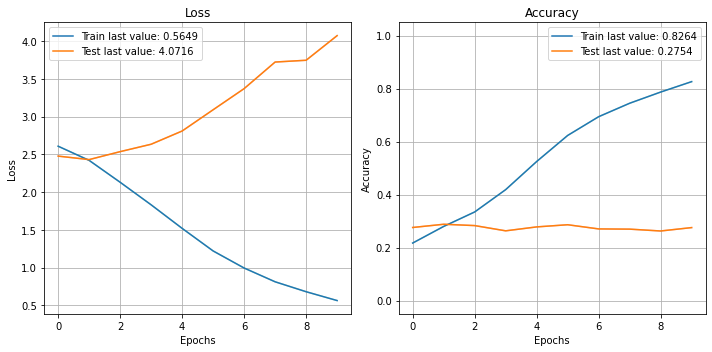

In [44]:
plot_history(history.history)
plt.show()

In [47]:
result = np.argmax(bi_directional_LSTM_model.predict(testing_padded), axis=-1)

In [48]:
print(classification_report(test_data['classes_id'].astype(int).tolist(), result, target_names=classes_names))

                      precision    recall  f1-score   support

               Egypt       0.56      0.63      0.60      1041
                Iraq       0.45      0.28      0.34       664
        Saudi_Arabia       0.18      0.30      0.22       520
          Mauritania       0.10      0.04      0.05        53
             Algeria       0.37      0.33      0.35       430
               Syria       0.09      0.07      0.08       278
                Oman       0.17      0.19      0.18       355
             Tunisia       0.13      0.08      0.10       173
             Lebanon       0.09      0.04      0.05       157
             Morocco       0.09      0.07      0.08       207
            Djibouti       0.00      0.00      0.00        27
United_Arab_Emirates       0.08      0.10      0.09       157
              Kuwait       0.03      0.02      0.02       105
               Libya       0.18      0.26      0.21       314
             Bahrain       0.04      0.04      0.04        52
       